In [ ]:
########################################################################################################
####################################### FOR TESTING ####################################################
########################################################################################################

In [ ]:
#!/usr/bin/env python3

In [25]:
from gensim.models import Word2Vec
from procrustes import smart_procrustes_align_gensim
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_col, theme_classic, scale_fill_manual, labs, element_text, theme
from spacy.lang.en import English
from scipy.spatial.distance import cosine

nlp = English(pipeline=[])
nlp.add_pipe("sentencizer")

In [2]:
def get_sentences(text: str) -> list[list[str]]:
    """Split the specified text into sentences, consisting of text tokens."""

    sents = []

    # We process the text in chunks by paragraph, ensuring that a sentence
    # never crosses a paragraph boundary:
    for para in text.split("\n\n"):
        doc = nlp(para.replace("\n", " "))
        for sent in doc.sents:
            tokens = [
                token.text.lower().strip() for token in sent if not token.is_space
            ]
            sents.append(tokens)

    return sents

In [8]:
def similarity_print(vec, target: str, subName: str, n: int = 10):

    print("Top " + str(n) + " words similar to " + target + " in " + subName + ":")

    for word, value in vec.most_similar(target, topn=n):

        print(f"{value: .2f} {word}")

In [ ]:
# Read and tokenize dem corpus from disc
with open("corpora/demText.txt") as f:
    demText = f.read()
    demSents = get_sentences(demText)

# Read and tokenize rep corpus from disc
with open("corpora/repText.txt") as f:
    repText = f.read()
    repSents = get_sentences(repText)

# TODO: ignore words with low frequencies
# TODO: find ideal threshold

demModel = Word2Vec(demSents, epochs=25, window=4)
repModel = Word2Vec(repSents, epochs=25, window=4)

print("Word2Vec models generated")

repModelAligned = smart_procrustes_align_gensim(demModel, repModel)

print("Embedding spaces aligned")

demVec = demModel.wv
repVec = repModelAligned.wv

In [ ]:
# Find least similar words
vocab = list(set(demVec.index_to_key) & set(repVec.index_to_key)) # Tokens used in both embedding spaces (intersection of both vocabularies)

# Filter to only tokens that are in both datasets
dVec = {token: demVec[token] for token in vocab}
rVec = {token: repVec[token] for token in vocab}

# Calculate each token's cosine similarity across the two embedding spaces
similarities = {token: cosine(dVec[token], rVec[token]) for token in vocab}
print(similarities["again"])
least_sim = sorted(similarities, key=lambda x: similarities[x])
#print(least_sim)
# Get the vectors of the 10 least similar words across embedding spaces
bottom_n = least_sim[:1000]
for token in bottom_n:
    print(f"TOKEN: {token}    SIMILARITY: {similarities[token]}")
    
    

In [47]:
TARGET = "racist"
words = []
values = []
communities = []

for word, value in demVec.most_similar(TARGET, topn=10):
    words.append(word)
    values.append(value)
    communities.append("r/democrats")

for word, value in repVec.most_similar(TARGET, topn=10):
    words.append(word)
    values.append(value)
    communities.append("r/republicans")

df = pd.DataFrame({
    "Community" : communities,
    "Word" : words,
    "Similarity" : values
})

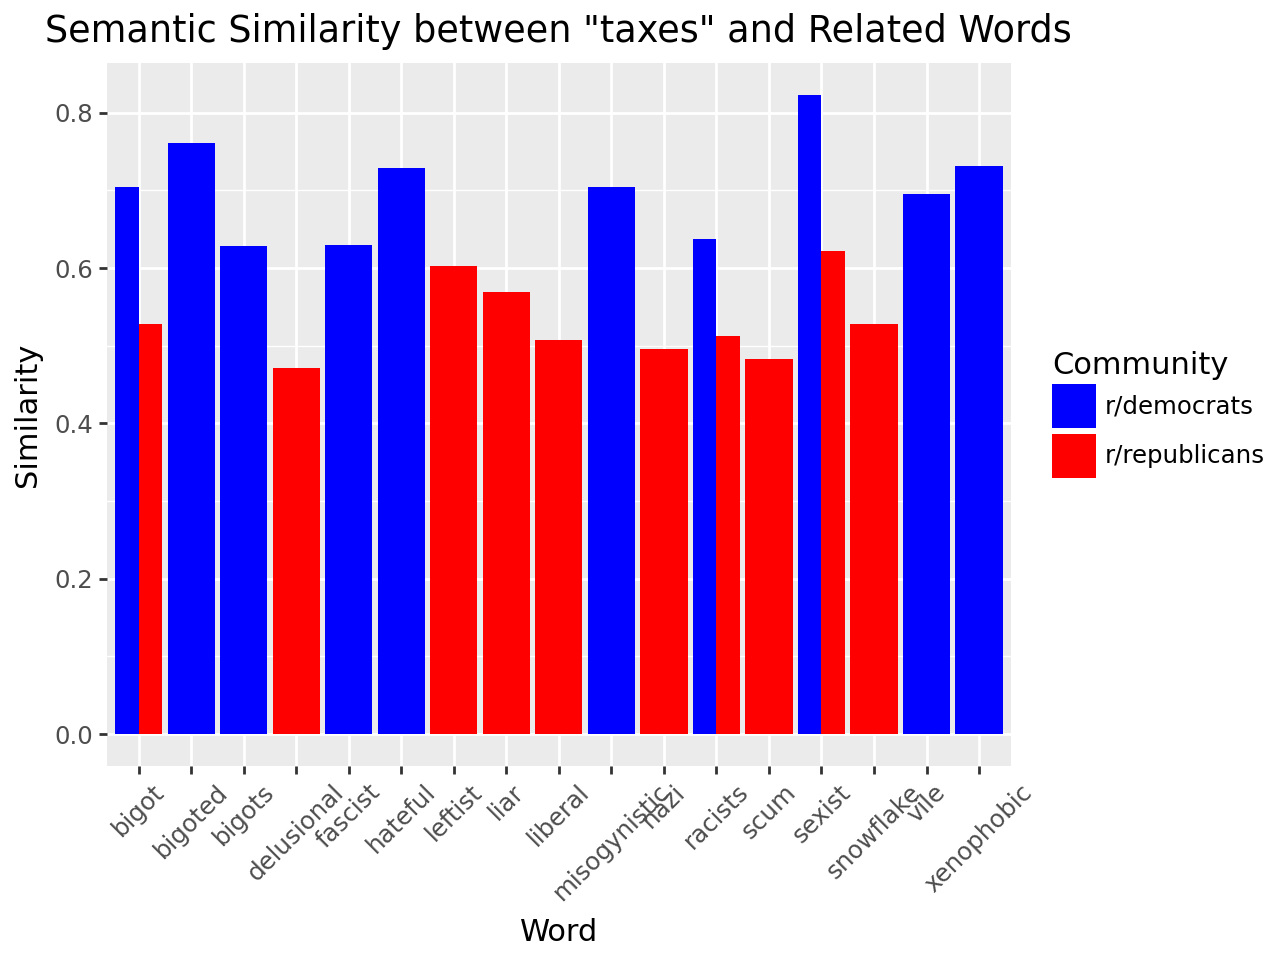

Top 10 words similar to taxes in democrats:
 0.73 tax
 0.69 wages
 0.68 profits
 0.67 premiums
 0.63 prices
 0.62 incomes
 0.61 debt
 0.61 salaries
 0.61 costs
 0.60 investments
Top 10 words similar to taxes in republicans:
 0.62 income
 0.60 tax
 0.58 wages
 0.58 costs
 0.58 rates
 0.56 subsidies
 0.55 programs
 0.54 benefits
 0.54 goods
 0.54 corporations


/home/jchidiac/.conda/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/jchidiac/.conda/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: taxes.png


In [48]:
p = (ggplot(df, aes(x="Word", y="Similarity", fill="Community")) +
 geom_col(position="dodge") +
 scale_fill_manual(values={"r/republicans" : "red", "r/democrats" : "blue"}) +
 labs(title='Semantic Similarity between "taxes" and Related Words') +
 theme(axis_text_x=element_text(angle=45)))

p.show()

p.save("taxes.png")

similarity_print(demVec, "taxes", "democrats")
similarity_print(repVec, "taxes", "republicans")